# __Step 4.4c: Fit trend line__

Goals here:
- Better detect the trends for topics

10/11/22:
- Think of this as a [forcasting problem](https://www.cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html).
- Update `sklearn` environment but run into problem:
 - `libstdc++.so.6: version 'GLIBCXX_3.4.29' not found`
 - [Fix](https://github.com/BVLC/caffe/issues/4953): `conda install libgcc`

10/10/22: 
- The topic over time heatmap is ordered in a unstatisfactory way. While I can tell if a topic is declining or rising, it is rather subjective. Looking into [non-linear regression models for time-series](https://otexts.com/fpp2/nonlinear-regression.html), I can get a better picture by fitting trend lines.
- From [this post](https://stackoverflow.com/questions/51321100/python-natural-smoothing-splines) found the following packages:
  - https://github.com/espdev/csaps
  - https://github.com/madrury/basis-expansions
- Here is another way using [pycaret](https://towardsdatascience.com/time-series-forecasting-with-pycaret-regression-module-237b703a0c63).

## ___Set up___

### Existing environment

```
conda activate sklearn
conda update --all
pip install skforecast
```

### Module import

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
from math import isnan
from scipy.interpolate import UnivariateSpline, CubicSpline
from datetime import datetime

# for recursive autoregressive forcasting
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster


### Key variables

In [2]:
# Reproducibility
seed = 20220609

# Setting working directory
proj_dir   = Path.home() / "projects/plant_sci_hist"
work_dir   = proj_dir / "4_topic_model/4_4_over_time"
work_dir.mkdir(parents=True, exist_ok=True)

# modified topic names
dir43            = proj_dir / "4_topic_model/4_3_model_analysis"
toc_mod_name_file= dir43 / 'fig4_3_topic_heatmap_seaborn_order_condensed.txt'

# Topic freuqency for each timestamp
toc_freq_file    = work_dir / 'table4_4_topics_over_time_df_no_global_tune.tsv'

# So PDF is saved in a format properly
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.family"] = "sans-serif"

## ___Load data___

### Load toc_mod_names

In [3]:
#https://www.adamsmith.haus/python/answers/how-to-set-column-names-when-importing-a-csv-into-a-pandas-dataframe-in-python
header_list   = ["Topic", "Name"]
toc_mod_names = pd.read_csv(toc_mod_name_file, sep='\t', names=header_list)
toc_mod_names.head()

,Topic,Name
0,-1,cell | expression | gene | protein
1,13,mirna | rnas | micrornas | target | lncrnas
2,21,circadian clock | rhythms | flowering | arabid...
3,0,allergen | pollen | ige | allergenic
4,1,medium | callus | regeneration | culture | som...


### Load and process top_freq

In [4]:
#https://stackoverflow.com/questions/28200404/pandas-read-table-use-first-column-as-index
top_freq      = pd.read_csv(toc_freq_file, index_col=0, sep='\t')
top_freq.head()

,Topic,Words,Frequency,Timestamp
0,-1,"cells, growth, acid, activity, tissue",981,250750799.0
1,0,"timothy, timothy pollen, antigen, ragweed, all...",8,250750799.0
2,1,"callus, medium, kinetin, culture, protoplasts",85,250750799.0
3,2,"berberinium, viscometric titrations, flow pola...",2,250750799.0
4,3,"amiben, atrazine, gsatrazine, atrazine metabol...",4,250750799.0


In [5]:
# Turn the dataframe into a matrix with rows as timestamps, column as topics,
# and values as frequency
top_freq_dict = {} # {timestamp:{topic:freq}}
for idx in top_freq.index:
  row  = top_freq.loc[idx]
  ts   = row["Timestamp"]
  toc  = row["Topic"]
  freq = row["Frequency"]
  if ts not in top_freq_dict:
    top_freq_dict[ts] = {toc:freq}
  elif toc not in top_freq_dict[ts]:
    top_freq_dict[ts][toc] = freq
  else:
    print("ERR: redundant", topic,freq)

In [8]:
# Fill in 0s
#ts_unique = top_freq.Timestamp.unique()
#topics    = top_freq.Topic.unique()

# Go through each ts_unique and topics
#for ts in ts_unique:
#  if ts not in top_freq_dict:
#    top_freq_dict[ts] = {}
#  for toc in topics:
#    if toc not in top_freq_dict[ts]:
#      top_freq_dict[ts][toc] = 0

# Realize that I can use DataFrame.fillna after dataframe is created
top_freq_df = pd.DataFrame.from_dict(top_freq_dict)
top_freq_df.fillna(0, inplace=True)
top_freq_df.sort_index(axis=0, inplace=True)  # sort rows
top_freq_df.sort_index(axis=1, inplace=True)  # sort columns
top_freq_df.index.name = "Topic"
top_freq_df.head()

,2.507508e+08,4.258800e+08,5.468400e+08,6.389460e+08,7.126416e+08,7.783920e+08,8.361936e+08,8.975376e+08,9.497268e+08,9.869616e+08,...,1.521864e+09,1.532750e+09,1.543986e+09,1.554178e+09,1.564027e+09,1.574053e+09,1.583557e+09,1.592712e+09,1.601438e+09,1.609477e+09
Topic,,,,,,,,,,,,,,,,,,,,,
-1,981.0,899.0,949.0,971.0,997.0,910.0,1013.0,1032.0,1139.0,1074,...,1050,960.0,1013.0,927,934.0,977.0,996.0,957,980.0,896.0
0,8.0,31.0,31.0,35.0,28.0,47.0,44.0,67.0,58.0,30,...,4,7.0,6.0,5,6.0,3.0,4.0,7,4.0,6.0
1,85.0,87.0,211.0,222.0,212.0,159.0,144.0,153.0,58.0,94,...,30,22.0,19.0,21,22.0,18.0,27.0,26,29.0,24.0
2,2.0,1.0,2.0,4.0,0.0,2.0,6.0,3.0,2.0,6,...,37,32.0,45.0,53,31.0,40.0,50.0,48,36.0,33.0
3,4.0,2.0,2.0,8.0,26.0,11.0,5.0,6.0,6.0,6,...,26,17.0,11.0,24,21.0,22.0,23.0,22,17.0,18.0


## ___Forcasting___ 

### Set up output folder

In [126]:
dir_forcast = work_dir / "_forcast"
dir_forcast.mkdir(parents=True, exist_ok=True)

### Function

In [139]:
def fit_forcaster(toc, row_series, steps_test, steps_future, dir_forcast):
  '''Fit recursive autoregressors with data for a topic
  Args:
    toc (int): topic
    row_series (Series): a pandas series with dates as indices and frequency as 
      values for a topic that derives from a row in the topic-timestamp 
      dataframe
    steps_test (int): number of data witheld for testing
    steps_future (int): number of months to predict into the future
    dir_forcast (Path): directory for forcast results
  Returns:
    predictions_future (Series): the future prediction values
  Output:
    plots (pdf): original data + predictions
    values (txt): original data + predictions
  '''
  x  = row_series.index.to_list()
  y  = row_series.values.tolist()

  # Turn timestamps to dates
  x_dates = [datetime.fromtimestamp(ts+1) for ts in x]
  # Change all dates to 1st day of the month. This is done otherwise anything
  # not on the 1st day of the month will be removed when df.asfreq is applied.
  x_dates = [datetime.strptime(d.strftime("%Y:%m"), "%Y:%m") for d in x_dates]

  # Create a pandas series with y using dates as indices
  y_df = pd.DataFrame({"date":x_dates, "y":y})
  y_df = y_df.set_index('date')

  # Set frequency to monthly and fill in missing data as NaN
  y_df = y_df.asfreq('MS') 
  y_df = y_df.sort_index() # make sure the date is sorted

  # impute missing data
  y_df['y_spline'] = y_df['y'].interpolate(option='spline')

  # Set last few months as test set
  data_train = y_df[:-steps]
  data_test  = y_df[-steps:]

  # train ForcasterAutoreg
  forecaster_ar = ForecasterAutoreg(
                  regressor = RandomForestRegressor(random_state=seed),
                  lags      = 6)

  # Lags used as predictors
  lags_grid = [10, 20]

  # Regressor's hyperparameters
  param_grid = {'n_estimators': [25, 50, 100, 200, 400], 
                'max_depth': [3, 5, 10]}

  results_grid = grid_search_forecaster(
                          forecaster         = forecaster_ar,
                          y                  = data_train['y_spline'],
                          param_grid         = param_grid,
                          lags_grid          = lags_grid,
                          steps              = steps,
                          refit              = True,
                          metric             = 'mean_squared_error',
                          initial_train_size = int(len(data_train)*0.5),
                          fixed_train_size   = False,
                          return_best        = True,
                          verbose            = False)

  # get best parameters
  num_lags     = len(results_grid.iloc[0]['lags'])
  max_depth    = results_grid.iloc[0]['max_depth']
  n_estimators = results_grid.iloc[0]['n_estimators'] 
  
  # generate final model
  regressor_rf = RandomForestRegressor(max_depth=5, n_estimators=100, 
                                     random_state=seed)
  forecaster_final = ForecasterAutoreg(regressor = regressor_rf,
                                      lags      = 20)
  forecaster_final.fit(y=data_train['y_spline'])

  # generate predictions
  predictions_test            = forecaster_final.predict(steps=steps_test)
  predictions_test_and_future = forecaster_final.predict(steps=steps_test + \
                                                               steps_future)
  predictions_future = predictions_test_and_future[steps_test:]

  # plot orignal, imputed, and prediction values
  fig, ax=plt.subplots(figsize=(9, 4))
  data_train['y_spline'].plot(ax=ax, label='train')
  data_test['y_spline'].plot(ax=ax, label='test')
  y_df['y'].plot(ax=ax, style='o', ms=5, label='original data')
  predictions_future.plot(ax=ax, label='predictions:test + future')
  fig.savefig(dir_forcast / f'figure4_4c_forcast_topic_{toc}.pdf')

  return predictions_future


### Itereate through topics and call fit_forcaster()

Number of models compared: 30.


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [01:59<00:00, 59.72s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 3, 'n_estimators': 50}
  Backtesting metric: 2025.8245132579927



fontTools.subset INFO  maxp pruned
fontTools.subset INFO  cmap pruned
fontTools.subset INFO  kern dropped
fontTools.subset INFO  post pruned
fontTools.subset INFO  FFTM dropped
fontTools.subset INFO  GPOS pruned
fontTools.subset INFO  GSUB pruned
fontTools.subset INFO  name pruned
fontTools.subset INFO  glyf pruned
fontTools.subset INFO  Added gid0 to subset
fontTools.subset INFO  Added first four glyphs to subset
fontTools.subset INFO  Closing glyph list over 'GSUB': 15 glyphs before
fontTools.subset INFO  Glyph names: ['.notdef', '.null', 'a', 'd', 'e', 'eight', 'five', 'nine', 'nonmarkingreturn', 'one', 'seven', 'space', 't', 'two', 'zero']
fontTools.subset INFO  Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 24, 26, 27, 28, 68, 71, 72, 87]
fontTools.subset INFO  Closed glyph list over 'GSUB': 15 glyphs after
fontTools.subset INFO  Glyph names: ['.notdef', '.null', 'a', 'd', 'e', 'eight', 'five', 'nine', 'nonmarkingreturn', 'one', 'seven', 'space', 't', 'two', 'zero']
fontTools.subset INFO  

2020-02-01    1033.845984
2020-03-01    1033.845984
2020-04-01    1033.845984
2020-05-01    1033.845984
2020-06-01    1033.845984
                 ...     
2029-09-01    1033.845984
2029-10-01    1033.845984
2029-11-01    1033.845984
2029-12-01    1033.845984
2030-01-01    1033.845984
Freq: MS, Name: pred, Length: 120, dtype: float64
Number of models compared: 30.


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [01:59<00:00, 59.58s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 3, 'n_estimators': 400}
  Backtesting metric: 35.216603111620444



fontTools.subset INFO  maxp pruned
fontTools.subset INFO  cmap pruned
fontTools.subset INFO  kern dropped
fontTools.subset INFO  post pruned
fontTools.subset INFO  FFTM dropped
fontTools.subset INFO  GPOS pruned
fontTools.subset INFO  GSUB pruned
fontTools.subset INFO  name pruned
fontTools.subset INFO  glyf pruned
fontTools.subset INFO  Added gid0 to subset
fontTools.subset INFO  Added first four glyphs to subset
fontTools.subset INFO  Closing glyph list over 'GSUB': 18 glyphs before
fontTools.subset INFO  Glyph names: ['.notdef', '.null', 'a', 'd', 'e', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 't', 'three', 'two', 'zero']
fontTools.subset INFO  Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 68, 71, 72, 87]
fontTools.subset INFO  Closed glyph list over 'GSUB': 18 glyphs after
fontTools.subset INFO  Glyph names: ['.notdef', '.null', 'a', 'd', 'e', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', '

2020-02-01    7.233474
2020-03-01    7.233474
2020-04-01    7.233474
2020-05-01    7.233474
2020-06-01    7.233474
                ...   
2029-09-01    7.233474
2029-10-01    7.233474
2029-11-01    7.233474
2029-12-01    7.233474
2030-01-01    7.233474
Freq: MS, Name: pred, Length: 120, dtype: float64
Number of models compared: 30.


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [03:00<00:00, 90.19s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 5, 'n_estimators': 200}
  Backtesting metric: 717.151521701251



fontTools.subset INFO  maxp pruned
fontTools.subset INFO  cmap pruned
fontTools.subset INFO  kern dropped
fontTools.subset INFO  post pruned
fontTools.subset INFO  FFTM dropped
fontTools.subset INFO  GPOS pruned
fontTools.subset INFO  GSUB pruned
fontTools.subset INFO  name pruned
fontTools.subset INFO  glyf pruned
fontTools.subset INFO  Added gid0 to subset
fontTools.subset INFO  Added first four glyphs to subset
fontTools.subset INFO  Closing glyph list over 'GSUB': 15 glyphs before
fontTools.subset INFO  Glyph names: ['.notdef', '.null', 'a', 'd', 'e', 'eight', 'five', 'nine', 'nonmarkingreturn', 'one', 'seven', 'space', 't', 'two', 'zero']
fontTools.subset INFO  Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 24, 26, 27, 28, 68, 71, 72, 87]
fontTools.subset INFO  Closed glyph list over 'GSUB': 15 glyphs after
fontTools.subset INFO  Glyph names: ['.notdef', '.null', 'a', 'd', 'e', 'eight', 'five', 'nine', 'nonmarkingreturn', 'one', 'seven', 'space', 't', 'two', 'zero']
fontTools.subset INFO  

2020-02-01    32.400195
2020-03-01    32.400195
2020-04-01    32.400195
2020-05-01    32.400195
2020-06-01    32.400195
                ...    
2029-09-01    32.400195
2029-10-01    32.400195
2029-11-01    32.400195
2029-12-01    32.400195
2030-01-01    32.400195
Freq: MS, Name: pred, Length: 120, dtype: float64


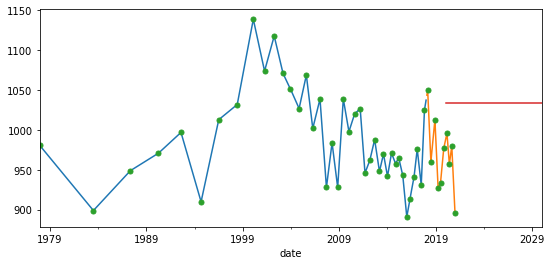

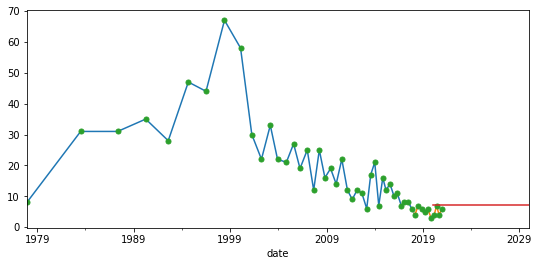

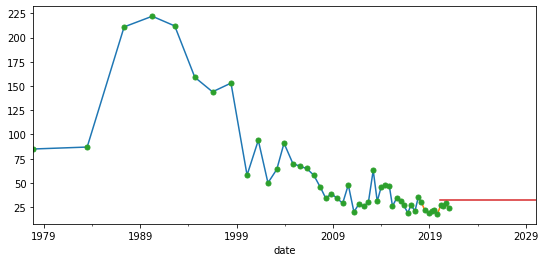

In [140]:
ts_unique    = top_freq_df.columns.to_list()
topics       = top_freq_df.index.to_list()
steps_test   = 24
steps_future = 120

c = 0
for toc in topics:
  row_series = top_freq_df.loc[toc]
  predictions_future = fit_forcaster(toc, row_series, steps_test, steps_future, 
                                     dir_forcast)
  print(predictions_future)
  if c == 2:
    break
  c += 1

## ___Code testing___

### Testing data

In [9]:
ts_unique = top_freq_df.columns.to_list()

data = top_freq_df.iloc[1]
x  = data.index.to_list()
y  = data.values.tolist()
x[:5], y[:5]

([250750799.0, 425879999.0, 546839999.0, 638945999.0, 712641599.0],
 [8.0, 31.0, 31.0, 35.0, 28.0])

### Scipy natural cubic smoothing spline

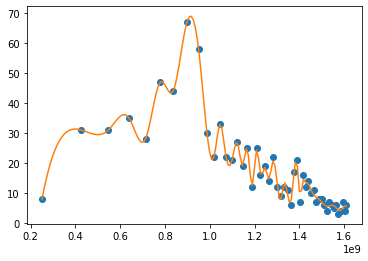

In [10]:
# Same cubic spline (k=3) as before
np.random.seed(seed)
spl    = UnivariateSpline(x, y, k=3, ext=0)
xs     = np.linspace(x[0], x[-1], 150) 
ys_spl = spl(xs)
plt.plot(x, y, 'o', xs, ys_spl, '-')
plt.show()

### Scipy cubic spline

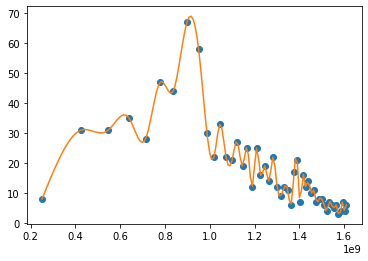

In [11]:
cs    = CubicSpline(x, y, bc_type='natural')
ys_cs = cs(xs)
plt.plot(x, y, 'o', xs, ys_cs, '-')
plt.show()

### Recursive autoregressive forecasting

https://www.cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html

#### Create dataframe

In [50]:
len(y)

50

In [65]:
# Turn timestamps to dates
x_dates = [datetime.fromtimestamp(ts+1) for ts in x]

# Change all dates to 1st day of the month. This is done otherwise anything
# not on the 1st day of the month will be removed when df.asfreq is applied.
x_dates = [datetime.strptime(d.strftime("%Y:%m"), "%Y:%m") for d in x_dates]
x_dates

[datetime.datetime(1977, 12, 1, 0, 0),
 datetime.datetime(1983, 7, 1, 0, 0),
 datetime.datetime(1987, 5, 1, 0, 0),
 datetime.datetime(1990, 4, 1, 0, 0),
 datetime.datetime(1992, 8, 1, 0, 0),
 datetime.datetime(1994, 9, 1, 0, 0),
 datetime.datetime(1996, 7, 1, 0, 0),
 datetime.datetime(1998, 6, 1, 0, 0),
 datetime.datetime(2000, 2, 1, 0, 0),
 datetime.datetime(2001, 4, 1, 0, 0),
 datetime.datetime(2002, 4, 1, 0, 0),
 datetime.datetime(2003, 3, 1, 0, 0),
 datetime.datetime(2003, 12, 1, 0, 0),
 datetime.datetime(2004, 11, 1, 0, 0),
 datetime.datetime(2005, 8, 1, 0, 0),
 datetime.datetime(2006, 4, 1, 0, 0),
 datetime.datetime(2007, 1, 1, 0, 0),
 datetime.datetime(2007, 9, 1, 0, 0),
 datetime.datetime(2008, 4, 1, 0, 0),
 datetime.datetime(2008, 11, 1, 0, 0),
 datetime.datetime(2009, 6, 1, 0, 0),
 datetime.datetime(2010, 1, 1, 0, 0),
 datetime.datetime(2010, 8, 1, 0, 0),
 datetime.datetime(2011, 3, 1, 0, 0),
 datetime.datetime(2011, 9, 1, 0, 0),
 datetime.datetime(2012, 3, 1, 0, 0),
 datetim

In [76]:
# Create a pandas series with y using dates as indices
y_df = pd.DataFrame({"date":x_dates, "y":y})
y_df = y_df.set_index('date')

# Set frequency to monthly and fill in missing data as NaN
y_df = y_df.asfreq('MS') 
y_df = y_df.sort_index() # make sure the date is sorted
print(f'#rows: {y_df.shape[0]}, #missing_val:{y_df.isnull().any(axis=1).sum()}')

#rows: 518, #missing_val:468


#rows: 518 #missing_val: 0


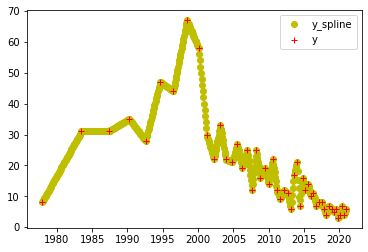

In [82]:
# impute missing data
y_df['y_spline'] = y_df['y'].interpolate(option='spline')
print('#rows:', y_df.shape[0], 
      '#missing_val:',y_df['y_spline'].isnull().any().sum())
plt.plot(y_df['y_spline'], 'yo')
plt.plot(y_df['y'], 'r+')
plt.legend(["y_spline", "y"])
plt.show()

In [83]:
# Verify that a temporary index is complete
(y_df.index == pd.date_range(start=y_df.index.min(),
                             end=y_df.index.max(),
                             freq=y_df.index.freq)).all()

True

In [115]:
# Set last few months as test set
steps = 36
data_train = y_df[:-steps]
data_test  = y_df[-steps:]

print(f"Train dates:{data_train.index.min()}-{data_train.index.max()} (n={len(data_train)})")
print(f"Test dates :{data_test.index.min()}-{data_test.index.max()} (n={len(data_test)})")

Train dates:1977-12-01 00:00:00-2018-01-01 00:00:00 (n=482)
Test dates :2018-02-01 00:00:00-2021-01-01 00:00:00 (n=36)


#### ForcasterAutoReg

In [116]:
forecaster_ar = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=seed),
                lags      = 6)

# Lags used as predictors
lags_grid = [5, 10, 20]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500], 'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster_ar,
                        y                  = data_train['y_spline'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False)


Number of models compared: 18.


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [02:09<00:00, 43.32s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5] 
  Parameters: {'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 29.65056558114687



In [117]:
# best result with smallest mse
results_grid.iloc[0]

lags                                        [1, 2, 3, 4, 5]
params                {'max_depth': 3, 'n_estimators': 500}
mean_squared_error                                29.650566
max_depth                                                 3
n_estimators                                            500
Name: 1, dtype: object

In [118]:
print("num_lags=",len(results_grid.iloc[0]['lags']))

num_lags= 5


#### Final model

In [119]:
regressor_rf = RandomForestRegressor(max_depth=5, n_estimators=100, 
                                     random_state=seed)
forecaster_final = ForecasterAutoreg(regressor = regressor_rf,
                                     lags      = 20)
forecaster_final.fit(y=data_train['y_spline'])
predictions_test = forecaster_final.predict(steps=steps)

In [134]:
type(predictions_test)

pandas.core.series.Series

In [120]:
# the next 10 years
steps_future = 120
predictions_future = forecaster_final.predict(steps=steps+steps_future)

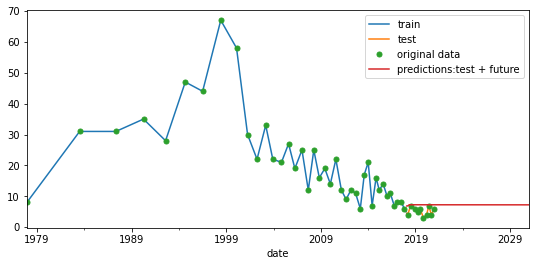

In [125]:
fig, ax=plt.subplots(figsize=(9, 4))
data_train['y_spline'].plot(ax=ax, label='train')
data_test['y_spline'].plot(ax=ax, label='test')
y_df['y'].plot(ax=ax, style='o', ms=5, label='original data')
predictions_future.plot(ax=ax, label='predictions:test + future')
ax.legend()

In [124]:
# Test error
error_mse = mean_squared_error(y_true = data_test['y_spline'],
                               y_pred = predictions_test)
print(f"Test error (mse): {error_mse}")

Test error (mse): 5.0891757995901825


In [136]:
predictions_future[steps:].shape

(120,)